In [1]:
# loading the mnist dataset
from tensorflow.keras.datasets.mnist import load_data

# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


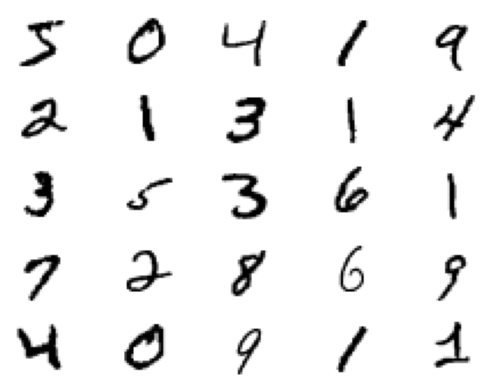

In [5]:
#plot of 25 images from the MNIST training dataset, arranged in a 5×5 square.


from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [10]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [11]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [12]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [13]:
#Batch and Shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
############# THE GENERATOR
# THE GENRATOR USES tf.keras.layers.Conv2DTranspose (upsmapling
#) layers to  produce an image from a random noise


In [16]:
#input 7*7*256(low resolution)
#outputs a single 28*28 image
# this generator takes a vector of size 100 and first reshape
# convultion in combination with  batch normalization
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    # First dense layer to expand the 100-dimensional vector to 7x7x256
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape output to 7x7x256
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    # First Conv2DTranspose layer to expand to 7x7x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 14x14x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


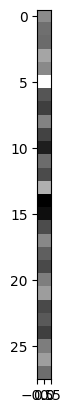

In [17]:
##### USE THE AS YET UNTRAINED GENRATOR TO CREATE AN IMAGE
# sample image generated by the generator
generator= make_generator_model()
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)
plt.imshow(generated_image[0,:,0],cmap='gray')



In [18]:
####THE DISCRIMINATOR
#input to discriminator=28*28*1 grayscale image
#output binary prediction(image is real claa=1 image is fake class=0)
# no pooling layers
#single node in theoutput layer with the sigmoid activation function
# downsampling from 28*28 to 14*14 then to 7*7
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [20]:

import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output layer with sigmoid activation
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output a single value between 0 and 1

    return model


In [21]:
# Assuming the generator model is created as make_generator_model()
generator = make_generator_model()

# Generate a random noise vector
random_noise = tf.random.normal([1, 100])

# Generate an image using the generator model
generated_image = generator(random_noise)

# Initialize the discriminator
discriminator = make_discriminator_model()

# Use the discriminator to classify the generated image
decision = discriminator(generated_image)
print(decision)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.5001353]], shape=(1, 1), dtype=float32)


In [22]:
#Discriminator loss
#This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the dis
#criminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [23]:
#Generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)


In [24]:
#The discriminator and the generator optimizers.
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [25]:
#Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
#Define the training loop
EPOCHS=50
noise_dim=100
num_examples_to_generate=16
# you wil reuse this seed overtime so it  will  be easier
#to visualize progress in the animated GIF
seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [28]:
#notice the use of 'tf.function'
# this annotation causes the function to be 'compiled'
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

NameError: name 'dataset' is not defined

In [31]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)


In [33]:
import tensorflow as tf
import time
from IPython import display

# Define the training loop
for epoch in range(EPOCHS):
    start = time.time()

    # Iterate over each batch in the dataset
    for image_batch in dataset:
        train_step(image_batch)  # train_step function should handle training on one batch

    # Produce images for the GIF as you go
    display.clear_output(wait=True)  # Clears the output for the current cell in a Jupyter notebook
    generate_and_save_images(generator, epoch + 1, seed)  # Generates and saves images for this epoch

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)  # Saves model checkpoint

    # Print the time taken for the epoch
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

# Generate after the final epoch
display.clear_output(wait=True)
generate_and_save_images(generator, EPOCHS, seed)


NameError: name 'dataset' is not defined

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [35]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [37]:
from google.colab import files
uploaded = files.upload()  # This will open a file picker


Saving image_at_epoch_0050.png to image_at_epoch_0050.png


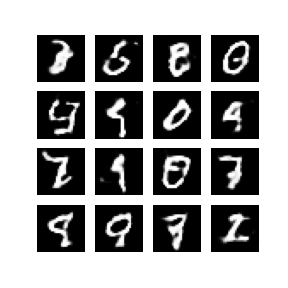

In [38]:
display_image(EPOCHS)

In [40]:
# Create a requirements.txt file with the necessary packages
requirements = """
tensorflow
numpy
matplotlib
Pillow
"""

# Write the requirements to a file
with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())


In [41]:
from google.colab import files

# Download the requirements.txt file
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>